# 4. Data Modeling

<a id="contents"></a>
# Table of Contents  
4.1. [Introduction](#introduction)  
4.2. [Imports](#imports)   
4.3. [Data Splitting and Normalization](#split)  
4.4. [Data Modeling](#model)
4.5. [Data Processing For LSTM](#ltsm)

## 4.1 Introduction<a id="introduction"></a>

The goal of this notebook is to develop a final model that effectively predicts stock market prices for ELF. 

## 4.2 Imports<a id="imports"></a>

In [1]:
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils import plot_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

2024-05-22 15:00:57.097666: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('/Users/heatheradler/Documents/GitHub/Springboard/Springboard_Projects/Stock_Predictor_Capstone/Updated_df.csv')
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,Dividends,Stock Splits,day,month,year,is_quarter_end,open-close,low-high,target
0,69546,24.000000,27.400000,23.730000,26.500000,13591500,0.0,0.0,22,9,2016,1,-2.500000,-3.670000,0
1,69547,25.670000,26.049999,24.129999,25.330000,2152500,0.0,0.0,23,9,2016,1,0.340000,-1.920000,0
2,69548,25.379999,25.760000,24.719999,25.260000,531800,0.0,0.0,26,9,2016,1,0.119999,-1.040001,0
3,69549,25.450001,25.500000,24.570000,24.600000,976700,0.0,0.0,27,9,2016,1,0.850000,-0.930000,1
4,69550,24.950001,26.799999,24.750000,26.540001,1071400,0.0,0.0,28,9,2016,1,-1.590000,-2.049999,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1891 non-null   int64  
 1   Open            1891 non-null   float64
 2   High            1891 non-null   float64
 3   Low             1891 non-null   float64
 4   Close           1891 non-null   float64
 5   Volume          1891 non-null   int64  
 6   Dividends       1891 non-null   float64
 7   Stock Splits    1891 non-null   float64
 8   day             1891 non-null   int64  
 9   month           1891 non-null   int64  
 10  year            1891 non-null   int64  
 11  is_quarter_end  1891 non-null   int64  
 12  open-close      1891 non-null   float64
 13  low-high        1891 non-null   float64
 14  target          1891 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 221.7 KB


## 4.3 Data Splitting and Normalization<a id="split"></a>

In [4]:
#features = df[['open-close', 'low-high', 'is_quarter_end']] 
#target = df['target'] 

#scaler = StandardScaler() 
#features = scaler.fit_transform(features) 

#X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.1, random_state=2022) 
#print(X_train.shape, X_valid.shape) 

In [5]:
#Set Target Variable
output_var = pd.DataFrame(df['Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [6]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
0,0.078959,0.090769,0.084746,1.000000
1,0.086807,0.084456,0.086737,0.154139
2,0.085444,0.083100,0.089674,0.034296
3,0.085773,0.081884,0.088927,0.067194
4,0.083423,0.087963,0.089823,0.074197


In [7]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

## 4.4 Data Modelling<a id="model"></a>

In [8]:
# Sample data
X_train = np.random.random((1000, 20))
y_train_continuous = np.random.random(1000)
X_valid = np.random.random((200, 20))
y_valid_continuous = np.random.random(200)

# Convert continuous target variable to binary class labels
y_train = (y_train_continuous > 0.5).astype(int)
y_valid = (y_valid_continuous > 0.5).astype(int)

# Define models
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()] 
  
# Fit models and evaluate
for i in range(3):
    models[i].fit(X_train, y_train)
    print(f'{models[i]} :')
    print('Training Accuracy :', metrics.roc_auc_score(y_train, models[i].predict_proba(X_train)[:, 1]))
    print('Validation Accuracy :', metrics.roc_auc_score(y_valid, models[i].predict_proba(X_valid)[:, 1]))
    print()

LogisticRegression() :
Training Accuracy : 0.5643884388438845
Validation Accuracy : 0.47370000000000007

SVC(kernel='poly', probability=True) :
Training Accuracy : 0.10559055905590559
Validation Accuracy : 0.4617

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) :
Training Accuracy : 1.0
Va

### Observations:
Among the three models, XGBClassifier has the highest performance but it is pruned to overfitting as the difference between the training and the validation accuracy is too high.

## 4.5 Data Processing For LSTM<a id="lstm"></a>

In [9]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [10]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

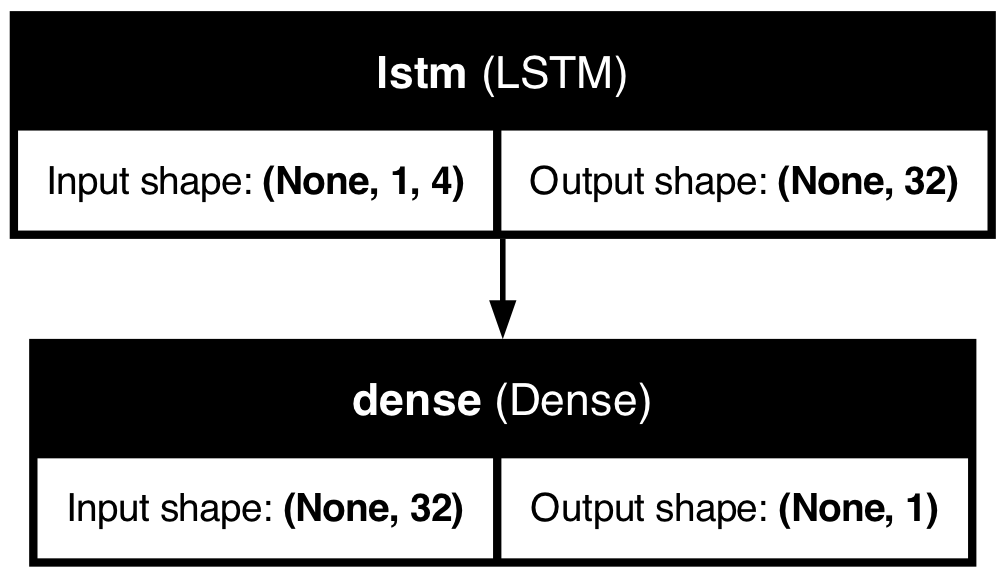

In [11]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [12]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 554.3173
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 549.3907
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 543.2999
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 535.4292
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 525.3337  
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 512.6776
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 497.2267
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 478.8620
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 457.5947
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 433.5751
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 407.0913
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 378.5586  
Epoch 13/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 348.4985
Epoch 14/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 317.5096  
Epoch 15/100
54/54 ━━━━━━━━

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.5669  
Epoch 81/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 25.6064
Epoch 82/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 24.6665
Epoch 83/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 23.7455
Epoch 84/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 22.8446
Epoch 85/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 21.9639
Epoch 86/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 21.1031
Epoch 87/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 20.2620
Epoch 88/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 19.4401
Epoch 89/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 18.6375
Epoch 90/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 17.8524
Epoch 91/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 17.0864
Epoch 92/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 16.3400
Epoch 93/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.6129
Epoch 94/100
54/54 ━━━━━━━━━━━━━━━━

In [13]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


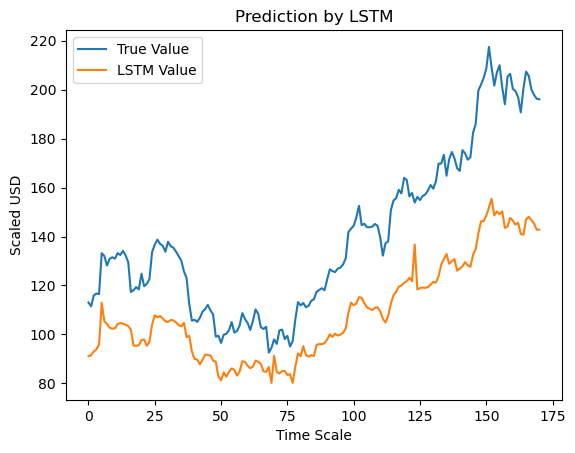

In [14]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()